In [1]:
import numpy as np
import tensorflow as tf
import random as rn
import os
import sys
from functools import reduce
from tensorflow.keras.optimizers import SGD
from sklearn.linear_model import LogisticRegression

import pandas as pd
import pyarrow.parquet as pq
import csv
import glob
from keras import models
from keras import layers
from keras import Input
import keras 
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from collections import Counter
from keras.callbacks import History
from tensorflow.keras.metrics import Recall
from tensorflow.keras.metrics import Precision
# import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline      # for warping
from transforms3d.axangles import axangle2mat  # for rotation
import keras_tuner as kt
from matplotlib import pyplot
import xlsxwriter
np.set_printoptions(threshold=sys.maxsize)


In [2]:
# ## 1. Jittering

# #### Hyperparameters :  sigma = standard devitation (STD) of the noise
def DA_Jitter(X, sigma=0.01):
    myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    return X + myNoise


# ## 2. Scaling

# #### Hyperparameters :  sigma = STD of the zoom-in/out factor
def DA_Scaling(X, sigma=0.5):
    scalingFactor = np.random.normal(loc=1.0, scale=sigma, size=(1, X.shape[1]))  # shape=(1,3)
    myNoise = np.matmul(np.ones((X.shape[0], 1)), scalingFactor)
    return X * myNoise


# ## 3. Magnitude Warping

# #### Hyperparameters :  sigma = STD of the random knots for generating curves
#
# #### knot = # of knots for the random curves (complexity of the curves)

# "Scaling" can be considered as "applying constant noise to the entire samples" whereas "Jittering" can be considered as "applying different noise to each sample".

# "Magnitude Warping" can be considered as "applying smoothly-varing noise to the entire samples"


## This example using cubic splice is not the best approach to generate random curves.
## You can use other aprroaches, e.g., Gaussian process regression, Bezier curve, etc.
def GenerateRandomCurves(X, sigma=0.2, knot=4):
    xx = (np.ones((X.shape[1], 1)) * (np.arange(0, X.shape[0], (X.shape[0] - 1) / (knot + 1)))).transpose()
    yy = np.random.normal(loc=1.0, scale=sigma, size=(knot + 2, X.shape[1]))
    x_range = np.arange(X.shape[0])
    random_curves = []
    for i in range(X.shape[-1]):
        cs = CubicSpline(xx[:, i], yy[:, i])
        random_curves.append(cs(x_range))
    return np.array(random_curves).transpose()


def DA_MagWarp(X, sigma=0.2):
    return X * GenerateRandomCurves(X, sigma)


# ## 4. Time Warping

# #### Hyperparameters :  sigma = STD of the random knots for generating curves
#
# #### knot = # of knots for the random curves (complexity of the curves)

def DistortTimesteps(X, sigma=0.2):
    tt = GenerateRandomCurves(X, sigma)  # Regard these samples aroun 1 as time intervals
    tt_cum = np.cumsum(tt, axis=0)  # Add intervals to make a cumulative graph
    # Make the last value to have X.shape[0]
    for i in range(X.shape[-1]):
        t_scale = (X.shape[0] - 1) / tt_cum[-1, i]
        tt_cum[:, i] = tt_cum[:, i] * t_scale
    return tt_cum


def DA_TimeWarp(X, sigma=0.2):
    tt_new = DistortTimesteps(X, sigma)
    X_new = np.zeros(X.shape)
    x_range = np.arange(X.shape[0])
    for i in range(X.shape[-1]):
        X_new[:, i] = np.interp(x_range, tt_new[:, i], X[:, i])
    return X_new


# ## 5. Permutation

# #### Hyperparameters :  nPerm = # of segments to permute
# #### minSegLength = allowable minimum length for each segment

def DA_Permutation(X, nPerm=4, minSegLength=10):
    X_new = np.zeros(X.shape)
    idx = np.random.permutation(nPerm)
    bWhile = True
    while bWhile:
        segs = np.zeros(nPerm + 1, dtype=int)
        segs[1:-1] = np.sort(np.random.randint(minSegLength, X.shape[0] - minSegLength, nPerm - 1))
        segs[-1] = X.shape[0]
        if np.min(segs[1:] - segs[0:-1]) > minSegLength:
            bWhile = False
    pp = 0
    for ii in range(nPerm):
        x_temp = X[segs[idx[ii]]:segs[idx[ii] + 1], :]
        X_new[pp:pp + len(x_temp), :] = x_temp
        pp += len(x_temp)
    return X_new


In [3]:
def augment_data(train_set, train_label, function):

    train_set_one = train_set
#     START AUGMENTING
    LABEL = []
    # select random indices
    number_of_rows = int(train_set_one.shape[0] * 0.5)

#     random indices has to be the same for every dimension so that the label can be accurate
    random_indices = np.sort(np.random.choice(train_set_one.shape[0]-1, size=int(number_of_rows), replace=False))
    train_set_one = train_set_one[random_indices,:]
    
    
    train_set_one = train_set_one.transpose()
    if function == 'scale':
        train_set_one = DA_Scaling(train_set_one)
    elif function == 'jitter':
        train_set_one = DA_Jitter(train_set_one)
    elif function == 'magWarp':
        train_set_one = DA_MagWarp(train_set_one)
    elif function == 'timeWarp':
        train_set_one = DA_TimeWarp(train_set_one)
    elif function == 'rotation':
        train_set_one = DA_Rotation(train_set_one)
    elif function == 'permutation':
        train_set_one = DA_Permutation(train_set_one)
    else:
        print("Error no augmentation function")
        return -1
    train_set_one = train_set_one.transpose()
        
    
    # take the label and add them as the label for the new augmented data
    LABEL = np.array(train_label[random_indices])
#     we have ARR which is of shape (6, row, col) with the augmented data
#     and train_set which is of shape (6, row, col) with the non augmented data
    
    train_set_augmented = np.concatenate((train_set, train_set_one), axis = 0)
    print(train_set[0,0])
    print(train_set_one[0,0])
    train_label = np.array(train_label)
    label_set_augmented = np.concatenate((train_label, LABEL))
    
    return train_set_augmented, label_set_augmented



In [4]:
def model_network():
    seed_value = 34567892
    os.environ['PYTHONHASHSEED']=str(seed_value)
    tf.random.set_seed(seed_value)

    
    model = Sequential()
    model.add(Input(shape=(2400,)))
    model.add(layers.BatchNormalization())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
#     opt = SGD(learning_rate=0.0001,momentum=0.4)
    opt = Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', Recall(), Precision()])
    return model

2022-06-02 11:52:33.700644: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
127/127 - 2s - loss: 0.6085 - accuracy: 0.6818 - recall: 0.6601 - precision: 0.6740 - 2s/epoch - 15ms/step
Epoch 2/100
127/127 - 1s - loss: 0.5560 - accuracy: 0.7338 - recall: 0.7696 - precision: 0.7056 - 852ms/epoch - 7ms/step
Epoch 3/100
127/127 - 1s - loss: 0.5227 - accuracy: 0.7571 - recall: 0.8042 - precision: 0.7234 - 768ms/epoch - 6ms/step
Epoch 4/100
127/127 - 1s - loss: 0.4957 - accuracy: 0.7786 - recall: 0.8413 - precision: 0.7371 - 780ms/epoch - 6ms/step
Epoch 5/100
127/127 - 1s - loss: 0.4762 - accuracy: 0.7845 - recall: 0.8560 - precision: 0.7389 - 637ms/epoch - 5ms/step
Epoch 6/100
127/127 - 1s - loss: 0.4523 - accuracy: 0.7995 - recall: 0.8695 - precision: 0.7532 - 719ms/epoch - 6ms/step
Epoch 7/100
127/127 - 1s - loss: 0.4497 - accuracy: 0.7937 - recall: 0.8660 - precision: 0.7469 - 735ms/epoch - 6ms/step
Epoch 8/100
127/127 - 1s - loss: 0.4372 - accuracy: 0.8030 - recall: 0.8790 - precision: 0.7537 - 810ms/epoch - 6ms/step
Epoch 9/100
127/127 - 1s - loss: 0

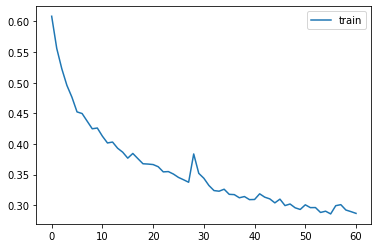

jitter
51.478270616630205
52.19334233319314
evaluate augmented :  jitter [0.19912587106227875, 0.9257196187973022, 0.9923809766769409, 0.8726968169212341]


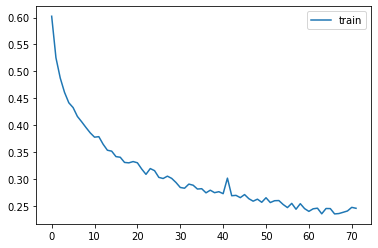

51.478270616630205
52.17784782611421
evaluate augmented :  jitter [0.21731466054916382, 0.9192200303077698, 0.9942857027053833, 0.8613861203193665]


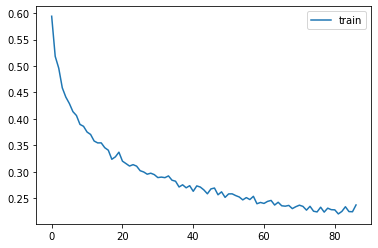

51.478270616630205
74.25528375349143
evaluate augmented :  jitter [0.18130946159362793, 0.9312906265258789, 0.9923809766769409, 0.8815566897392273]


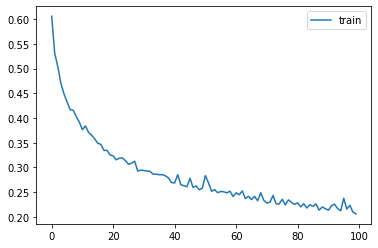

51.478270616630205
51.47164212905943
evaluate augmented :  jitter [0.22455936670303345, 0.9108635187149048, 0.9885714054107666, 0.8522167205810547]


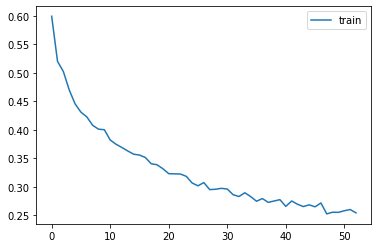

51.478270616630205
51.46702395372256
evaluate augmented :  jitter [0.24098952114582062, 0.9043639898300171, 0.9428571462631226, 0.8714788556098938]


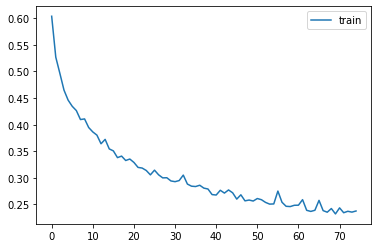

51.478270616630205
46.429449276351335
evaluate augmented :  jitter [0.19266928732395172, 0.9275766015052795, 0.9847618937492371, 0.8807495832443237]


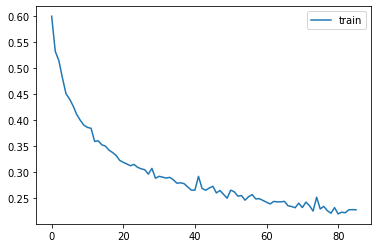

51.478270616630205
46.452108341522376
evaluate augmented :  jitter [0.2171860784292221, 0.9229340553283691, 0.9676190614700317, 0.8850173950195312]


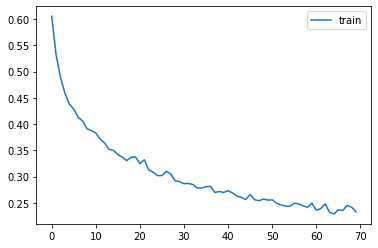

51.478270616630205
51.458694117489706
evaluate augmented :  jitter [0.21603117883205414, 0.9192200303077698, 0.9904761910438538, 0.8637873530387878]


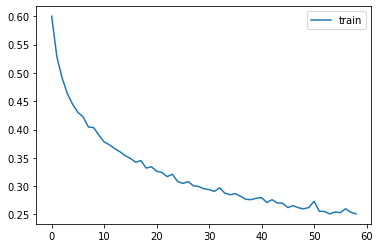

51.478270616630205
83.49898898940296
evaluate augmented :  jitter [0.20364148914813995, 0.9257196187973022, 0.9828571677207947, 0.8790460228919983]


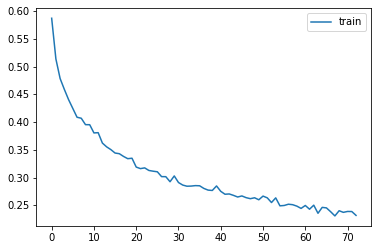

51.478270616630205
51.4756312360493
evaluate augmented :  jitter [0.1816011220216751, 0.9285051226615906, 0.9904761910438538, 0.8783783912658691]


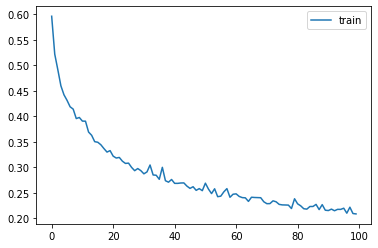

[92.57196187973022, 91.92200303077698, 93.12906265258789, 91.08635187149048, 90.43639898300171, 92.75766015052795, 92.29340553283691, 91.92200303077698, 92.57196187973022, 92.85051226615906]
92.15% (+/- 0.80%)
scale
51.478270616630205
96.75205398913225
evaluate augmented :  scale [0.23283624649047852, 0.9117920398712158, 0.9866666793823242, 0.8547855019569397]


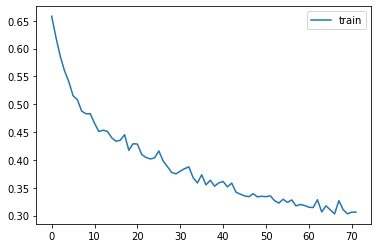

51.478270616630205
42.497086008922444
evaluate augmented :  scale [0.2843451499938965, 0.8737233281135559, 0.9466666579246521, 0.8214876055717468]


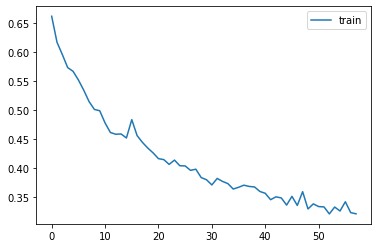

51.478270616630205
57.16049169103056
evaluate augmented :  scale [0.2546825408935547, 0.9062209725379944, 0.9980952143669128, 0.8397436141967773]


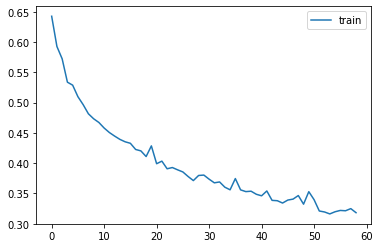

51.478270616630205
22.156862181559976
evaluate augmented :  scale [0.23903055489063263, 0.9108635187149048, 0.9847618937492371, 0.8545454740524292]


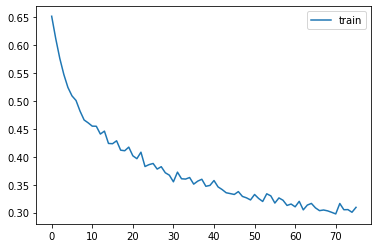

51.478270616630205
92.88373618770974
evaluate augmented :  scale [0.25031739473342896, 0.903435468673706, 0.9885714054107666, 0.8411669135093689]


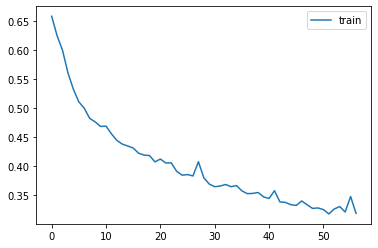

51.478270616630205
48.07305916014764
evaluate augmented :  scale [0.2613592743873596, 0.8913649320602417, 0.9961904883384705, 0.8197492361068726]


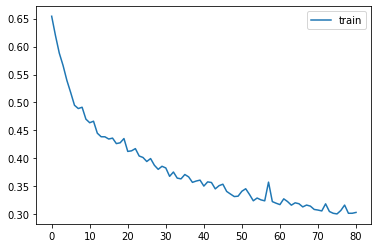

51.478270616630205
42.83074295252414
evaluate augmented :  scale [0.3058140277862549, 0.8662952780723572, 0.9504761695861816, 0.8087520003318787]


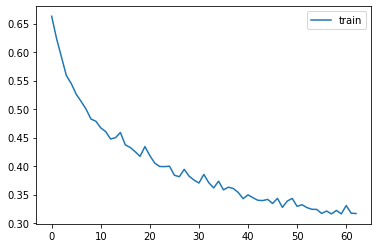

51.478270616630205
52.80972958982362
evaluate augmented :  scale [0.2910395860671997, 0.8867223858833313, 0.9980952143669128, 0.8124030828475952]


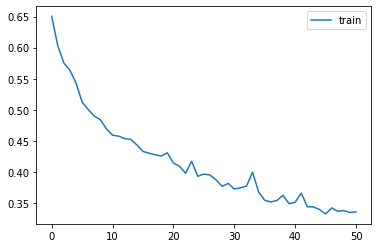

51.478270616630205
49.22426062975618
evaluate augmented :  scale [0.2142774611711502, 0.9173630475997925, 0.9809523820877075, 0.8670033812522888]


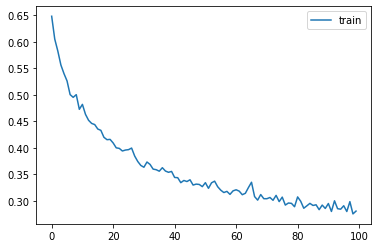

51.478270616630205
52.0303525777783
evaluate augmented :  scale [0.265762597322464, 0.8904364109039307, 0.977142870426178, 0.8287560343742371]


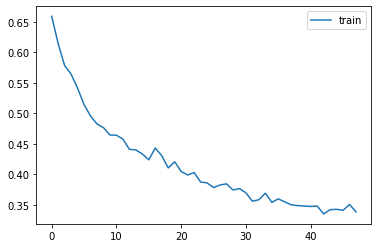

[91.17920398712158, 87.37233281135559, 90.62209725379944, 91.08635187149048, 90.3435468673706, 89.13649320602417, 86.62952780723572, 88.67223858833313, 91.73630475997925, 89.04364109039307]
89.58% (+/- 1.61%)
magWarp
51.478270616630205
48.68620791857136
evaluate augmented :  magWarp [0.24427539110183716, 0.903435468673706, 0.9961904883384705, 0.8367999792098999]


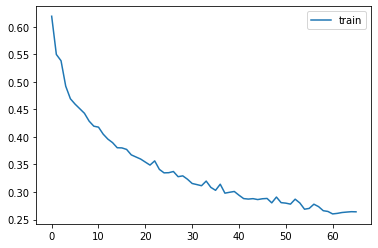

51.478270616630205
57.86804502910777
evaluate augmented :  magWarp [0.23508475720882416, 0.9099349975585938, 0.9847618937492371, 0.8531352877616882]


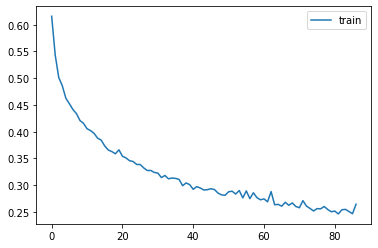

51.478270616630205
57.192567887025064
evaluate augmented :  magWarp [0.2395389825105667, 0.9080780148506165, 0.9733333587646484, 0.8573825359344482]


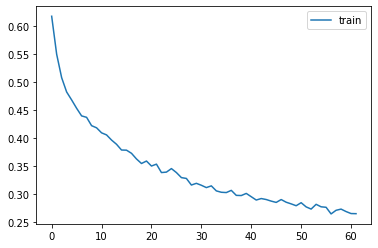

51.478270616630205
52.24286739206274
evaluate augmented :  magWarp [0.25957152247428894, 0.892293393611908, 0.9752380847930908, 0.8325203061103821]


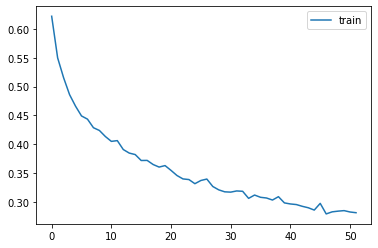

51.478270616630205
61.209119891692964
evaluate augmented :  magWarp [0.24580608308315277, 0.9015784859657288, 0.9942857027053833, 0.8352000117301941]


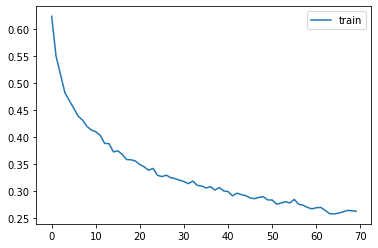

51.478270616630205
56.343523996970916
evaluate augmented :  magWarp [0.22860752046108246, 0.9145775437355042, 0.9828571677207947, 0.8614357113838196]


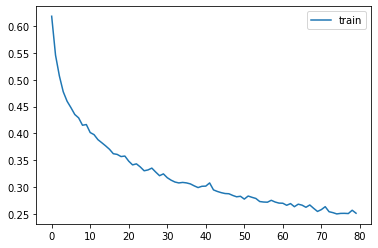

51.478270616630205
59.064899792886244
evaluate augmented :  magWarp [0.2162255495786667, 0.9127205014228821, 0.9942857027053833, 0.8515497446060181]


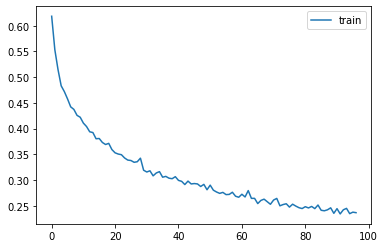

51.478270616630205
65.66190725659953
evaluate augmented :  magWarp [0.2195919305086136, 0.9090064764022827, 0.9904761910438538, 0.8482871055603027]


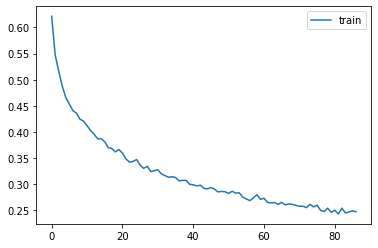

51.478270616630205
52.46825611227032
evaluate augmented :  magWarp [0.22705422341823578, 0.9108635187149048, 0.9904761910438538, 0.8510638475418091]


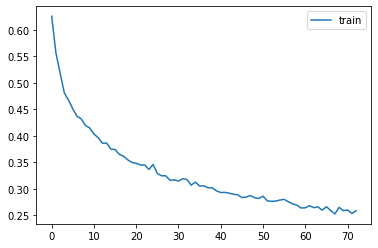

51.478270616630205
58.30312955533271
evaluate augmented :  magWarp [0.241282120347023, 0.9052924513816833, 0.9904761910438538, 0.8427876830101013]


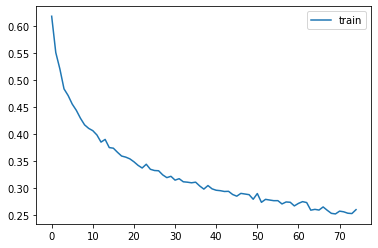

[90.3435468673706, 90.99349975585938, 90.80780148506165, 89.2293393611908, 90.15784859657288, 91.45775437355042, 91.27205014228821, 90.90064764022827, 91.08635187149048, 90.52924513816833]
90.68% (+/- 0.62%)
timeWarp
51.478270616630205
51.478270616630205
evaluate augmented :  timeWarp [0.22223588824272156, 0.9127205014228821, 0.9752380847930908, 0.8634064197540283]


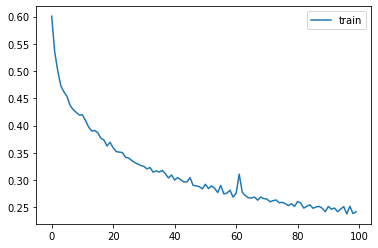

51.478270616630205
51.478270616630205
evaluate augmented :  timeWarp [0.21874576807022095, 0.9145775437355042, 0.9942857027053833, 0.8543371558189392]


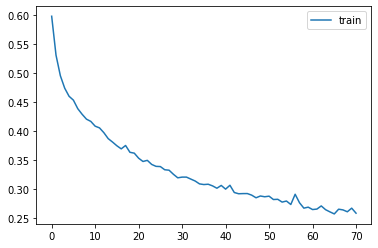

51.478270616630205
83.48741311208623
evaluate augmented :  timeWarp [0.20149247348308563, 0.9257196187973022, 0.9904761910438538, 0.8739495873451233]


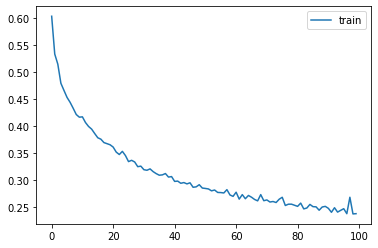

51.478270616630205
52.184146876088576
evaluate augmented :  timeWarp [0.2291911393404007, 0.9071494936943054, 0.9733333587646484, 0.85594642162323]


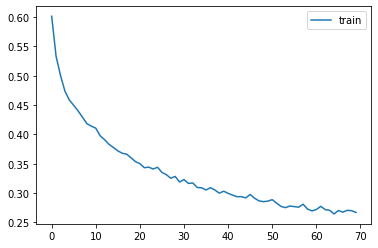

51.478270616630205
51.478270616630205
evaluate augmented :  timeWarp [0.2068823128938675, 0.9229340553283691, 0.977142870426178, 0.8784246444702148]


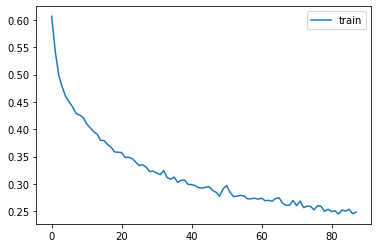

51.478270616630205
46.45108937047337
evaluate augmented :  timeWarp [0.21957425773143768, 0.9164345264434814, 0.9657142758369446, 0.8756476640701294]


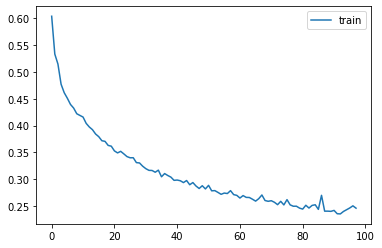

51.478270616630205
52.184146876088576
evaluate augmented :  timeWarp [0.22039900720119476, 0.9173630475997925, 0.9885714054107666, 0.8621262311935425]


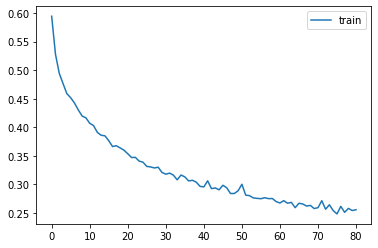

51.478270616630205
46.45108937047337
evaluate augmented :  timeWarp [0.22689062356948853, 0.9136490225791931, 0.9942857027053833, 0.8529411554336548]


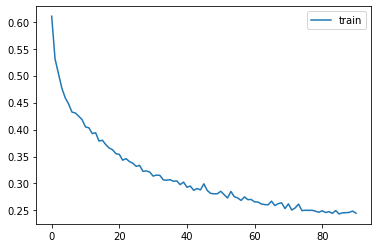

51.478270616630205
46.45108937047337
evaluate augmented :  timeWarp [0.22682015597820282, 0.9108635187149048, 0.9733333587646484, 0.861720085144043]


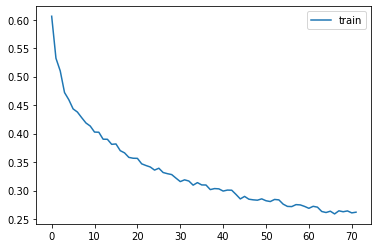

51.478270616630205
52.184146876088576
evaluate augmented :  timeWarp [0.21015313267707825, 0.9229340553283691, 0.9847618937492371, 0.8733108043670654]


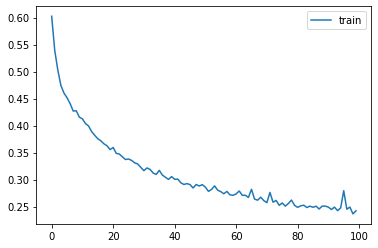

[91.27205014228821, 91.45775437355042, 92.57196187973022, 90.71494936943054, 92.29340553283691, 91.64345264434814, 91.73630475997925, 91.36490225791931, 91.08635187149048, 92.29340553283691]
91.64% (+/- 0.56%)
permutation
51.478270616630205
62.89090256149931
evaluate augmented :  permutation [0.22391429543495178, 0.9164345264434814, 0.9942857027053833, 0.8571428656578064]


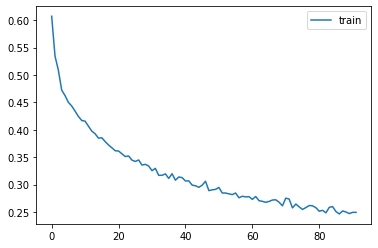

51.478270616630205
51.537607627828436
evaluate augmented :  permutation [0.2518146336078644, 0.893221914768219, 0.9809523820877075, 0.8306451439857483]


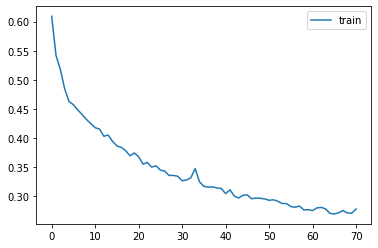

51.478270616630205
94.46966983386
evaluate augmented :  permutation [0.23803293704986572, 0.902506947517395, 0.977142870426178, 0.8465346693992615]


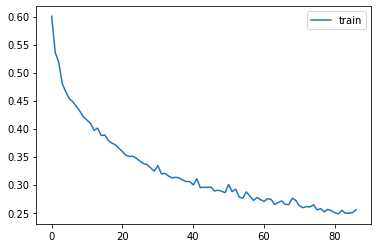

51.478270616630205
48.06262191141886
evaluate augmented :  permutation [0.2776936888694763, 0.89415043592453, 0.9561904668807983, 0.84654301404953]


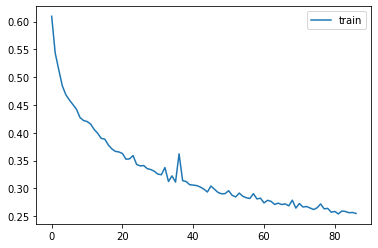

51.478270616630205
39.84873743294761
evaluate augmented :  permutation [0.23627282679080963, 0.9117920398712158, 0.9923809766769409, 0.851307213306427]


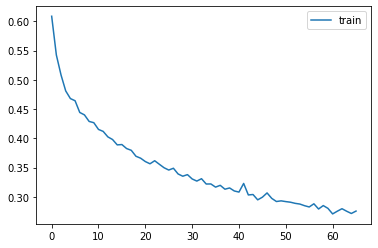

51.478270616630205
81.99074021791414
evaluate augmented :  permutation [0.21743060648441315, 0.9164345264434814, 0.9980952143669128, 0.8548123836517334]


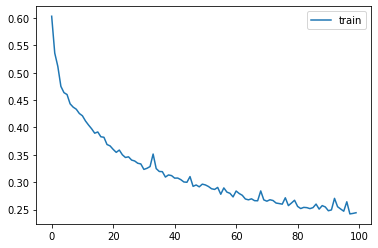

51.478270616630205
57.60221892427409
evaluate augmented :  permutation [0.20084914565086365, 0.9285051226615906, 0.9866666793823242, 0.8809523582458496]


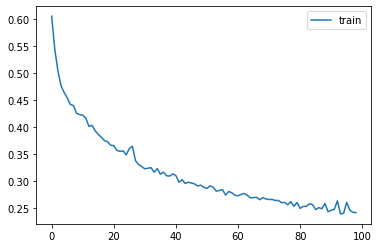

51.478270616630205
76.87227678933095
evaluate augmented :  permutation [0.25406065583229065, 0.9015784859657288, 0.9676190614700317, 0.8509212732315063]


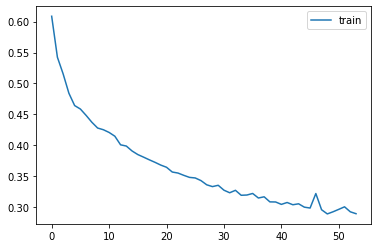

51.478270616630205
74.27335491278147
evaluate augmented :  permutation [0.2286643236875534, 0.9173630475997925, 0.9904761910438538, 0.860927164554596]


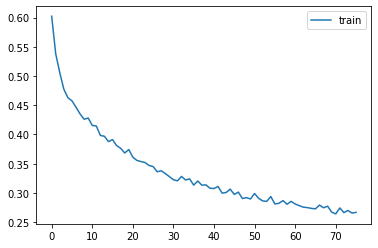

51.478270616630205
62.53048236252297
evaluate augmented :  permutation [0.26640692353248596, 0.8997214436531067, 0.9657142758369446, 0.8492462038993835]


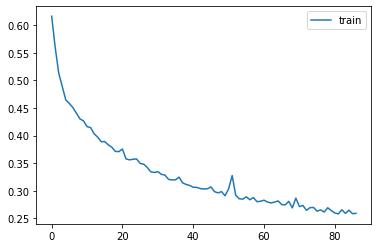

[91.64345264434814, 89.3221914768219, 90.2506947517395, 89.415043592453, 91.17920398712158, 91.64345264434814, 92.85051226615906, 90.15784859657288, 91.73630475997925, 89.97214436531067]
90.82% (+/- 1.10%)


In [5]:
# for each technique run tec_len times the model to obtain an average of accuracy and fill the csv table with results
techniques = ['jitter', 'scale', 'magWarp', 'timeWarp', 'permutation']
# techniques = ['jitter','scale']

arr_eda, arr_bvc,arr_acc,arr_tem = [],[],[],[]
std_arr = []
arr_eda_percentage, arr_bvc_percentage,arr_acc_percentage,arr_tem_percentage = [],[],[],[]
tec_eda, tec_bvc, tec_acc, tec_tem = 0,0,0,0

recall_eda, recall_bvc, recall_acc, recall_tem = [],[],[],[]
precision_eda, precision_bvc, precision_acc, precision_tem = [],[],[],[]

train_set = np.load('train_set_original.npy',  encoding='ASCII')
train_label = np.load('train_label_original.npy',  encoding='ASCII')
test_set = np.load('test_set.npy',  encoding='ASCII')
test_label = np.load('test_label.npy',  encoding='ASCII')
train_label = train_label.reshape(train_label.shape[0], 1)
test_label = test_label.reshape(test_label.shape[0], 1)




# for dim in range(0, 4):
train_set_arr = train_set[2]
test_set_arr = test_set[2]

model = model_network()

# ORIGINAL SET
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
history = model.fit(train_set_arr, train_label, epochs=100, batch_size= 128, shuffle=True, verbose=2, callbacks=[callback])
scores1 = model.evaluate(test_set_arr, test_label, verbose=0)
print("evaluate original: ",scores1)
tec_eda = scores1[1]
recall_original = scores1[2]
precision_original = scores1[3]

recall_eda.append(recall_original)
precision_eda.append(precision_original)

pyplot.plot(history.history['loss'], label='train')
pyplot.legend()
pyplot.show()
            
# --------------------------------------------------------------------


for technique in techniques:
    print(technique)
    avg_tec_eda = []
    
    recall_original, precision_original, recall_aug, precision_aug = 0,0,0,0
    cvscores = []
    
    tec_len = 10
    
# loop tec_len times to get the average of a tecnique
    for avg_t in range(0, tec_len):
        train_set = np.load('train_set_original.npy',  encoding='ASCII')
        train_label = np.load('train_label_original.npy',  encoding='ASCII')
        test_set = np.load('test_set.npy',  encoding='ASCII')
        test_label = np.load('test_label.npy',  encoding='ASCII')
        train_label = train_label.reshape(train_label.shape[0], 1)
        test_label = test_label.reshape(test_label.shape[0], 1)

        train_set_arr_augment, label_set_augmented = augment_data(train_set[2], train_label, technique)
        test_set_arr = test_set[2]
        model = model_network()
        

        #     --------------------------------------------------------------------
        # AUGMENTATION
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
        history = model.fit(train_set_arr_augment, label_set_augmented, epochs=100, batch_size= 128, shuffle=True,verbose=0, callbacks = [callback])
        scores2 = model.evaluate(test_set_arr, test_label,verbose=0)

        print("evaluate augmented : ", technique, scores2)

        avg_tec_eda.append(scores2[1])
        std_arr.append(scores2[1])
        cvscores.append(scores2[1] * 100)
        recall_aug += scores2[2]
        precision_aug += scores2[3]

        pyplot.plot(history.history['loss'], label='train')
        pyplot.legend()
        pyplot.show()
 

    arr_eda.append(np.mean(avg_tec_eda))
    recall_eda.append(recall_aug/tec_len)
    precision_eda.append(precision_aug/tec_len)
    print(cvscores)
    print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
    std_arr.append(np.std(cvscores))

    arr_eda_percentage.append(round((np.mean(avg_tec_eda) - tec_eda) * 100, 4))


# insert eda and baseline
arr_eda.insert(0, tec_eda)
std_arr.insert(0, 0)
# recall_eda.insert(0, recall_original)
# precision_eda.insert(0, precision_original)

arr_eda.insert(0, 'EDA')
recall_eda.insert(0, 'RECALL')
precision_eda.insert(0, 'PRECISION')
std_arr.insert(0, 'STD')


header = ['sensor', 'baseline', 'jitter', 'scale', 'magWarp', 'timeWarp', 'permutation']

with open('table_accuracy.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    writer.writerow(arr_eda)
    writer.writerow(recall_eda)
    writer.writerow(precision_eda)
    writer.writerow(std_arr)
    writer.writerow([])
    arr_eda_percentage.insert(0, 0)
    arr_eda_percentage.insert(0, 'EDA')
    writer.writerow(arr_eda_percentage)


